# Initialization

## Data Processing & Import Modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["font.family"] = "serif"
% matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LeakyReLU
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Waseda/4.3 Inaba Zemi/Senior Thesis/Data/"
df1 = pd.read_csv(path +'df_master_final.csv', index_col='date')
df1.index = pd.to_datetime(df1.index)

Mounted at /content/drive


## 40 Days

In [ ]:
df = df1.copy()
## Drop if modification are made
#df = df.drop(columns={'Dead', 'PCR_negative', 'ComparisonPreDay', 'Tested\_MA(7days)', 
                      #'Light-Mid\_Symptoms', 'ComparisonPreSpread', 'Severe\_Symptoms'})


In [ ]:
df.columns

Index(['Positive\_Rate', 'Discharged', 'PCR\_Positive'], dtype='object')

In [1]:
df_training = df[:-40].copy()
df_master = df.copy()

#Separate dates for future plotting
train_dates = pd.DataFrame(df_training.index)
predict_period_dates = pd.DataFrame(df_master[-40:].index)

#Variables for training
cols = list(df_master)[0:10]

df_for_training = df_training[cols].astype(float)
df_for_plot=df_for_training.tail(100)
df_for_plot.plot.line()

NameError: ignored

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
#We use all the columns because when we want to reinverse the data to get the original variable back, they espect us to input 5 columns.
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# define the Autoencoder model
model40 = Sequential()

# First Layer
model40.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Second Layer
model40.add(LSTM(512, return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Third Layer
model40.add(LSTM(256, return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Fourth Layer
model40.add(LSTM(64, return_sequences=False))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

# Output Layer
model40.add(Dense(trainY.shape[1]))

# Compile
model40.compile(optimizer='adam', loss='mse')

# fit the model
history40 = model40.fit(trainX, trainY, epochs=500, batch_size=32, validation_split=0.1, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 128)           71168     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 128)           0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 14, 256)           394240    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 256)           0         
                                                                 
 dropout_5 (Dropout)         (None, 14, 256)           0         
                                                                 
 lstm_6 (LSTM)               (None, 14, 128)          

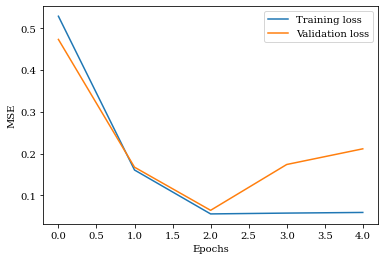

In [ ]:
plt.plot(history40.history['loss'], label='Training loss')
plt.plot(history40.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Mult_40Days_Training.png', dpi=100)

In [ ]:
n_past = 40
n_days_for_prediction=40  #let us predict past 15 days
#Make prediction
prediction = model40.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})

original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-40])
df_pred_plot = pd.concat([original_pred, df_forecast])
df_pred_plot.to_csv("LSTM_Mult_40days.csv")

rmse = sqrt(mean_squared_error(df_forecast, original[-40:]))
print(rmse)

0.026105043379588803


In [ ]:
# Import modules
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LeakyReLU
from sklearn.preprocessing import StandardScaler
import seaborn as sns
plt.rcParams["font.family"] = "serif"
% matplotlib inline

# Prepare dataframes
df1 = pd.read_csv(path +'df_master_final.csv', index_col='date')
df1.index = pd.to_datetime(df1.index)
df = df1.copy()
## Drop if modification are made
#df = df.drop(columns={'Dead', 'PCR_negative', 'ComparisonPreDay', 'Tested\_MA(7days)', 
                      #'Light-Mid\_Symptoms', 'ComparisonPreSpread', 'Severe\_Symptoms'})

# 40 Days Prediction LSTM (Multivariate)
## Split data
df_training = df[:-40].copy()
df_master = df.copy()

## Separate dates for future plotting
train_dates = pd.DataFrame(df_training.index)
predict_period_dates = pd.DataFrame(df_master[-40:].index)

## Variables for training
cols = list(df_master)[0:10]

## Plot the used data features
df_for_training = df_training[cols].astype(float)
df_for_plot=df_for_training.tail(100)
df_for_plot.plot.line()

## normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

## Prepare training data
trainX = []
trainY = []
### Number of days we look into the future and the past days we use to predict the future
n_future = 1
n_past = 14 
### Reformat input data into a shape
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

## define the LSTM model
model40 = Sequential()

### First Layer
model40.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

### Second Layer
model40.add(LSTM(512, return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

### Third Layer
model40.add(LSTM(256, return_sequences=True))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

### Fourth Layer
model40.add(LSTM(64, return_sequences=False))
model40.add(LeakyReLU(alpha=0.181818))
model40.add(Dropout(0.4))

### Output Layer
model40.add(Dense(trainY.shape[1]))

### Compile
model40.compile(optimizer='adam', loss='mse')

### Fit the model
history40 = model40.fit(trainX, trainY, epochs=500, batch_size=32, validation_split=0.1, verbose=1)

## Plot the accuracy preformance results
plt.plot(history40.history['loss'], label='Training loss')
plt.plot(history40.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Mult_40Days_Training.png', dpi=100)

## Make prediction
n_past = 40
n_days_for_prediction=40  
prediction = model40.predict(trainX[-n_days_for_prediction:])
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
### Convert the data into a dataframe
df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})
original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-40])
df_pred_plot = pd.concat([original_pred, df_forecast])
### Evaluate our LSTM model
rmse = sqrt(mean_squared_error(df_forecast, original[-40:]))

## Plot the prediction result
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
### Save figure
plt.savefig('LSTM_Mult_40Days.png', dpi=100)

# 40 Days Prediction GRU (Multivariate)
## define the GRU model
modelG40 = Sequential()

### First Layer
modelG40.add(GRU(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
modelG40.add(LeakyReLU(alpha=0.181818))
modelG40.add(Dropout(0.4))

### Second Layer
modelG40.add(GRU(512, return_sequences=True))
modelG40.add(LeakyReLU(alpha=0.181818))
modelG40.add(Dropout(0.4))

### Third Layer
modelG40.add(GRU(256, return_sequences=True))
modelG40.add(LeakyReLU(alpha=0.181818))
modelG40.add(Dropout(0.4))

### Fourth Layer
modelG40.add(GRU(64, return_sequences=False))
modelG40.add(LeakyReLU(alpha=0.181818))
modelG40.add(Dropout(0.4))

### Output Layer
modelG40.add(Dense(trainY.shape[1]))

### Compile
modelG40.compile(optimizer='adam', loss='mse')

### Fit the model
historyG40 = modelG40.fit(trainX, trainY, epochs=500, batch_size=32, validation_split=0.1, verbose=1)

## Plot the accuracy preformance results
plt.plot(historyG40.history['loss'], label='Training loss')
plt.plot(historyG40.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('GRU_Mult_40Days_Training.png', dpi=100)

## Make prediction
n_past = 40
n_days_for_prediction=40  
predictionG = modelG40.predict(trainX[-n_days_for_prediction:])
prediction_copies = np.repeat(predictionG, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
### Convert the data into a dataframe
df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})
original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-40])
df_pred_plot = pd.concat([original_pred, df_forecast])
### Evaluate our LSTM model
rmse = sqrt(mean_squared_error(df_forecast, original[-40:]))

## Plot the prediction result
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
### Save figure
plt.savefig('GRU_Mult_40Days.png', dpi=100)

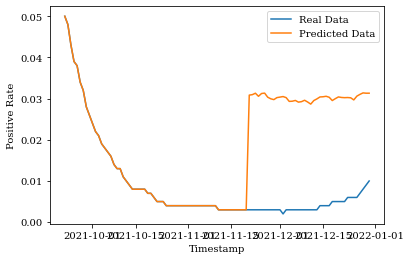

In [ ]:
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
plt.savefig('LSTM_Mult_40Days.png', dpi=100)

## 20 Days

In [ ]:
df_training = df[:-20].copy()
df_master = df.copy()

#Separate dates for future plotting
train_dates = pd.DataFrame(df_training.index)
predict_period_dates = pd.DataFrame(df_master[-20:].index)

#Variables for training
cols = list(df_master)[0:10]

df_for_training = df_training[cols].astype(float)
df_for_plot=df_for_training.tail(100)
df_for_plot.plot.line()

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
#We use all the columns because when we want to reinverse the data to get the original variable back, they espect us to input 5 columns.
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# define the Autoencoder model
model20 = Sequential()

# First Layer
model20.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model20.add(LeakyReLU(alpha=0.181818))

# Second Layer
model20.add(LSTM(512, return_sequences=True))
model20.add(LeakyReLU(alpha=0.181818))
model20.add(Dropout(0.4))

# Third Layer
model20.add(LSTM(256, return_sequences=True))
model20.add(LeakyReLU(alpha=0.181818))
model20.add(Dropout(0.4))

# Fourth Layer
model20.add(LSTM(64, return_sequences=False))
model20.add(LeakyReLU(alpha=0.181818))

# Output Layer
model20.add(Dense(trainY.shape[1]))
model20.compile(optimizer='adam', loss='mse')

# fit the model
history20 = model20.fit(trainX, trainY, epochs=500, batch_size=32, validation_split=0.1, verbose=1)

In [ ]:
plt.plot(history20.history['loss'], label='Training loss')
plt.plot(history20.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Mult_20Days_Training.png', dpi=100)

In [ ]:
n_past = 20
n_days_for_prediction=20  #let us predict past 15 days
#Make prediction
prediction = model20.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})

original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-20])
df_pred_plot = pd.concat([original_pred, df_forecast])
df_pred_plot.to_csv("LSTM_Mult_20days.csv")

rmse = sqrt(mean_squared_error(df_forecast, original[-20:]))
print(rmse)

In [ ]:
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
plt.savefig('LSTM_Mult_20Days.png', dpi=100)

## 80 Days

In [ ]:
df_training = df[:-80].copy()
df_master = df.copy()

#Separate dates for future plotting
train_dates = pd.DataFrame(df_training.index)
predict_period_dates = pd.DataFrame(df_master[-80:].index)

#Variables for training
cols = list(df_master)[0:10]

df_for_training = df_training[cols].astype(float)
df_for_plot=df_for_training.tail(100)
df_for_plot.plot.line()

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
#We use all the columns because when we want to reinverse the data to get the original variable back, they espect us to input 5 columns.
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 21  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
# define the Autoencoder model
model80 = Sequential()

# First Layer
model80.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model80.add(LeakyReLU(alpha=0.181818))

# Second Layer
model80.add(LSTM(512, return_sequences=True))
model80.add(LeakyReLU(alpha=0.181818))
model80.add(Dropout(0.4))

# Third Layer
model80.add(LSTM(256, return_sequences=True))
model80.add(LeakyReLU(alpha=0.181818))
model80.add(Dropout(0.4))

# Fourth Layer
model80.add(LSTM(64, return_sequences=False))
model80.add(LeakyReLU(alpha=0.181818))

# Output Layer
model80.add(Dense(trainY.shape[1]))
model80.compile(optimizer='adam', loss='mse')
model80.summary()

# fit the model
history80 = model80.fit(trainX, trainY, epochs=500, batch_size=32, validation_split=0.1, verbose=1)

In [ ]:
plt.plot(history80.history['loss'], label='Training loss')
plt.plot(history80.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Mult_80Days_Training.png', dpi=100)

In [ ]:
n_past = 80
n_days_for_prediction=80  #let us predict past 15 days
#Make prediction
prediction = model80.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

df_forecast = pd.DataFrame({'date':predict_period_dates.values.T[0], 'Positive\_Rate':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.index = df_forecast['date']
df_forecast = df_forecast.drop(columns={'date'})

original = pd.DataFrame(df_master['Positive\_Rate'][-100:])
original_pred = pd.DataFrame(df_master['Positive\_Rate'][-100:-80])
df_pred_plot = pd.concat([original_pred, df_forecast])
df_pred_plot.to_csv("LSTM_Mult_80days.csv")

rmse = sqrt(mean_squared_error(df_forecast, original[-80:]))
print(rmse)

In [ ]:
sns.lineplot(data=original, x=original.index, y=original['Positive\_Rate'])
sns.lineplot(data=df_pred_plot, x=df_pred_plot.index, y=df_pred_plot['Positive\_Rate'])
plt.xlabel('Timestamp')
plt.ylabel('Positive Rate')
plt.legend(['Real Data', 'Predicted Data'])
plt.savefig('LSTM_Mult_80Days.png', dpi=100)